In [30]:
import simexpal
import pandas as pd
import yaml
import numpy as np
from matplotlib import pyplot as plt
from statistics import geometric_mean

In [2]:
def parse(run, f):
    output = yaml.load(f, Loader=yaml.Loader)
    exp = output['Runs'][0]
    if 'Results' in exp:
        res = []
        # exp['Result'] = [{Focus Node, Value, Gain, Time, Original Value, AddedEdgeList},...]
        algo_name = run.experiment.name
        if '_single' in algo_name:
            algo_name = algo_name[:-7]
        if 'Dyn' in algo_name:
            algo_name = algo_name[:-3]
        variants = [run.experiment.variation[i].name for i in range(len(run.experiment.variation))]
        if variants.count('focus-50') > 0:
            num_focus_nodes = 50
        elif variants.count('focus-100') > 0:
            num_focus_nodes = 100
        elif variants.count('focus-25') > 0:
            num_focus_nodes = 25
        else:
            num_focus_nodes = None
        
        for result in exp['Results']:
            single_res = {
                'Experiment': algo_name + 'JLT' if 'Linalg' in exp and 'JLT' in exp['Linalg'] else algo_name,
                'Instance': run.instance.shortname,
                'Revision': run.experiment.revision.name,
                'k': exp['k'] or None,
                'Linalg': exp['Linalg'] if 'Linalg' in exp else None,
                'Algorithm': exp['Algorithm'] if 'Algorithm' in exp else None,
                'InitTime': exp['InitTime'] if 'InitTime' in exp else None,
                'Focus Node': result['Focus Node'] if 'Focus Node' in result else None,
                '#Focus Nodes': num_focus_nodes,
                'Gain': result['Gain'] if 'Gain' in result else None,
                'Time': result['Time'] if 'Time' in result else None,
                'Reset Time': result['Reset Time'] if 'Reset Time' in result else None,
                'status': str(run.get_status()),
            }
            res.append(single_res)
    return res

In [3]:
size_ordered = [
    'inf-power',
    'facebook_ego_combined',
    'web-spam',
    'wiki-Vote',
    'p2p-Gnutella09',
    'p2p-Gnutella04',
    'web-indochina-2004',
    'arxiv-heph',
    'web-webbase-2001',
    'arxiv-astro-ph',
    'as-caida20071105',
    'cit-HepTh',
    'ia-email-EU',
]
#'orange', 'royalblue', 'magenta', 'lightgreen','darkgreen' , 'gold', 'plum'
colormap = {
    'simplStoch': 'orange',
    'simplStochJLT': 'royalblue',
    'colStoch': 'magenta',
    'colStochJLT': 'lightgreen',
    'specStoch': 'darkgreen',
    'stGreedy': 'plum',
}

small_graphs = [
    'inf-power',
    'facebook_ego_combined',
    'web-spam',
    'wiki-Vote',
    'p2p-Gnutella09',
]

medium_graphs = [
    'p2p-Gnutella04',
    'web-indochina-2004'
    'arxiv-heph',
    'web-webbase-2001',
    'arxiv-astro-ph',
    'as-caida20071105',
    'cit-HepTh',
    'ia-email-EU'
]

In [4]:
cfg = simexpal.config_for_dir()
results = []

for run in cfg.discover_all_runs():
    if run.experiment.revision.name == 'k-lrip' and 'medium-graphs' in run.instance.instsets:
        with run.open_output_file() as f:
            for res in parse(run, f):
                results.append(res)

results = pd.DataFrame(results)

In [5]:
# add amortized time
results['Amortized Time'] = results['Time'] + results['InitTime'] / results['#Focus Nodes']

In [6]:
# sort by experiment (pandas uses this ordering when sorting the bars in bar plots) for consistency with GRIP plots
results['Experiment'] = pd.Categorical(results['Experiment'], ['simplStoch', 'simplStochJLT', 'colStoch', 'colStochJLT', 'specStoch', 'stGreedy'])
results['k'] = pd.Categorical(results['k'], [2, 5, 20])
results.sort_values('Experiment', inplace=True)
results

,Experiment,Instance,Revision,k,Linalg,Algorithm,InitTime,Focus Node,#Focus Nodes,Gain,Time,Reset Time,status,Combined Time
2871,simplStoch,arxiv-astro-ph,local-addition-v3,2,None,simplStoch,1158.8400,4397,25,541203.0,0.883468,0.394166,finished,47.237068
3197,simplStoch,arxiv-astro-ph,local-addition-v3,20,None,simplStoch,1159.8800,4822,25,1468910.0,5.170540,0.400727,finished,51.565740
3196,simplStoch,arxiv-astro-ph,local-addition-v3,20,None,simplStoch,1159.8800,4397,25,1534000.0,5.170470,0.400646,finished,51.565670
3195,simplStoch,arxiv-astro-ph,local-addition-v3,20,None,simplStoch,1159.8800,4161,25,1503280.0,5.170300,0.400527,finished,51.565500
3194,simplStoch,arxiv-astro-ph,local-addition-v3,20,None,simplStoch,1159.8800,3330,25,1439020.0,5.168310,0.400708,finished,51.563510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4992,stGreedy,arxiv-astro-ph,local-addition-v3,20,None,stGreedy,1158.3100,3330,25,2098060.0,5.114710,0.387385,finished,51.447110
4993,stGreedy,arxiv-astro-ph,local-addition-v3,20,None,stGreedy,1158.3100,4161,25,2152430.0,5.117590,0.387441,finished,51.449990
4994,stGreedy,arxiv-astro-ph,local-addition-v3,20,None,stGreedy,1158.3100,4397,25,2168440.0,5.115870,0.387516,finished,51.448270
4996,stGreedy,arxiv-astro-ph,local-addition-v3,20,None,stGreedy,1158.3100,4978,25,2139390.0,5.114120,0.387396,finished,51.446520


In [7]:
# relative speedup and quality compared to stGreedy
def normalize_group(group):
    if 'stGreedy' in group['Experiment'].unique():
        group['Relative Speedup'] = float(group.loc[group['Experiment'] == 'stGreedy']['Amortized Time']) / group['Amortized Time']
        group['Relative Quality'] = group['Gain'] / float(group.loc[group['Experiment'] == 'stGreedy']['Gain'])
        return group.loc[group['Experiment'] != 'stGreedy'][['Experiment', 'Relative Speedup', 'Relative Quality']]

normalized_results = results.loc[(results['status'] == 'finished')].groupby(['k', 'Instance', 'Focus Node'], group_keys=True).apply(lambda group: normalize_group(group))
normalized_results = normalized_results.reset_index(['k', 'Instance', 'Focus Node'])
normalized_results

,k,Instance,Focus Node,Experiment,Relative Speedup,Relative Quality
2865,2,arxiv-astro-ph,6,simplStoch,1.009428,0.976729
1901,2,arxiv-astro-ph,6,simplStochJLT,0.367020,0.943515
0,2,arxiv-astro-ph,6,colStoch,0.154791,1.000000
936,2,arxiv-astro-ph,6,colStochJLT,0.377428,0.933030
3840,2,arxiv-astro-ph,6,specStoch,0.108987,0.014019
...,...,...,...,...,...,...
3514,20,wiki-Vote,7062,simplStoch,1.006372,0.493783
2542,20,wiki-Vote,7062,simplStochJLT,0.227846,0.469919
623,20,wiki-Vote,7062,colStoch,0.251769,0.728122
1577,20,wiki-Vote,7062,colStochJLT,0.218208,0.611252


<Axes: xlabel='Instance', ylabel='Time (s)'>

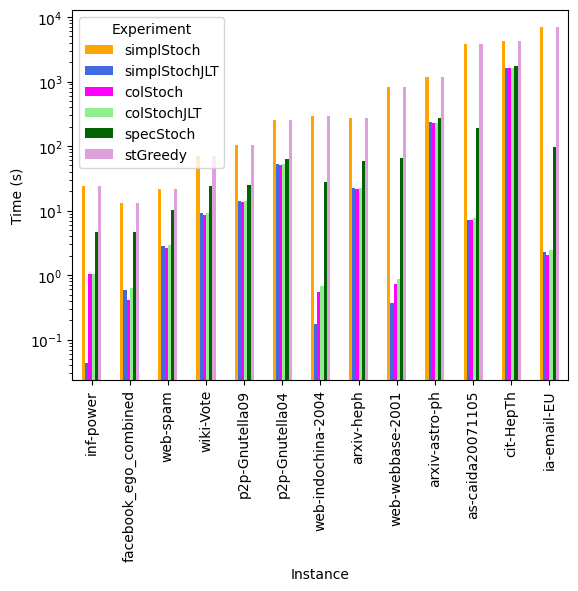

In [8]:
# plot preprocessing time
results.pivot_table(values='InitTime', index='Instance', columns='Experiment').loc[size_ordered].plot(kind='bar', logy=True, title='', ylabel='Time (s)', color=colormap)

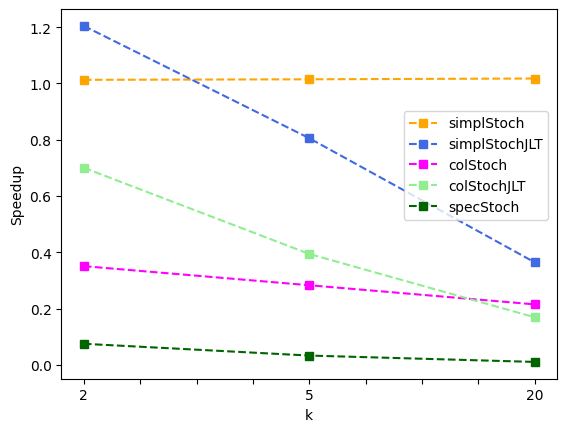

In [50]:
# 

normalized_results.loc[(normalized_results['Instance'].isin(small_graphs))].pivot_table(values='Relative Speedup', index='k', columns='Experiment', aggfunc=geometric_mean).plot(kind='line', ylabel='Speedup', title='', linestyle='--', marker='s', color=colormap)
plt.legend(loc=(0.69,0.43))

In [51]:
normalized_results.loc[(normalized_results['Instance'].isin(small_graphs))].pivot_table(values='Relative Speedup', index='k', columns='Experiment', aggfunc=geometric_mean)

Experiment,simplStoch,simplStochJLT,colStoch,colStochJLT,specStoch
k,,,,,
2,1.012781,1.204305,0.350947,0.700360,0.075097
5,1.014675,0.805341,0.283080,0.394238,0.033246
20,1.017443,0.364355,0.215072,0.169207,0.010662


<Axes: xlabel='k', ylabel='Speedup'>

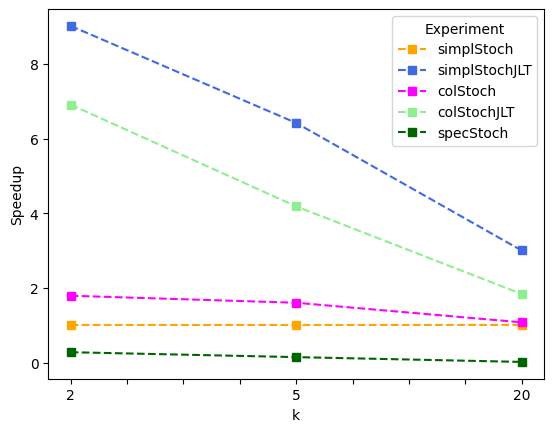

In [39]:
# 
normalized_results.loc[(normalized_results['Instance'].isin(medium_graphs))].pivot_table(values='Relative Speedup', index='k', columns='Experiment', aggfunc=geometric_mean).plot(kind='line', ylabel='Speedup', title='', linestyle='--', marker='s', color=colormap)

In [52]:
normalized_results.loc[(normalized_results['Instance'].isin(medium_graphs))].pivot_table(values='Relative Speedup', index='k', columns='Experiment', aggfunc=geometric_mean)

Experiment,simplStoch,simplStochJLT,colStoch,colStochJLT,specStoch
k,,,,,
2,1.005711,9.019683,1.789052,6.908846,0.275940
5,1.004426,6.419241,1.601381,4.183974,0.144546
20,1.007388,3.002071,1.076599,1.836555,0.015610


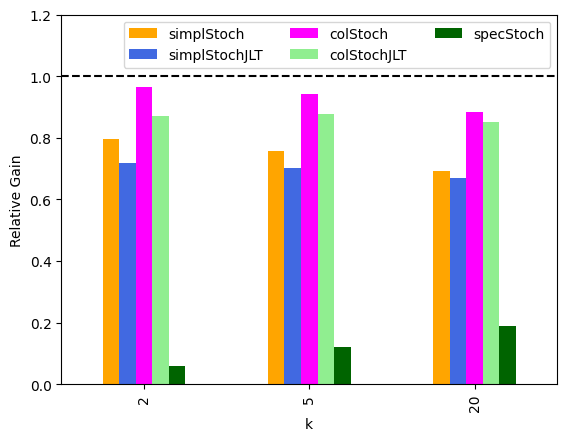

In [34]:
# 
normalized_results.pivot_table(values='Relative Quality', index='k', columns='Experiment', aggfunc=geometric_mean).plot(kind='bar', ylabel='Relative Gain', title='', color=colormap, ylim=(0,1.2))
plt.legend(ncol=3)
plt.axhline(y=1, linestyle='--', color='black')

<Axes: xlabel='k', ylabel='Time (s)'>

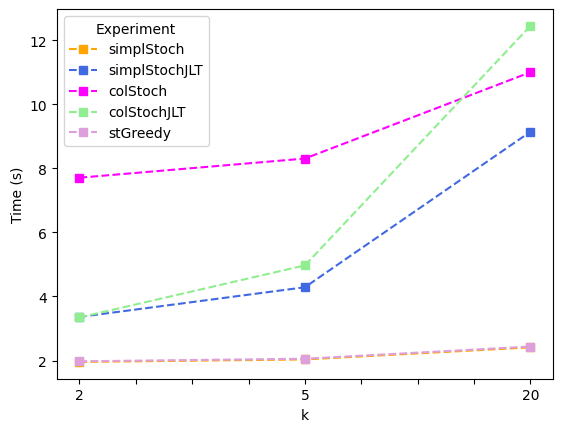

In [58]:
small_pvt = results.loc[(results['Instance'].isin(small_graphs)) & (results['Experiment'] != 'specStoch') & (results['status'] == 'finished')].pivot_table(values='Amortized Time', index='k', columns='Experiment')
small_pvt.plot(kind='line', ylabel='Time (s)', title='', linestyle='--', marker='s', color=colormap)
# plt.legend(loc=(1.01,.35))

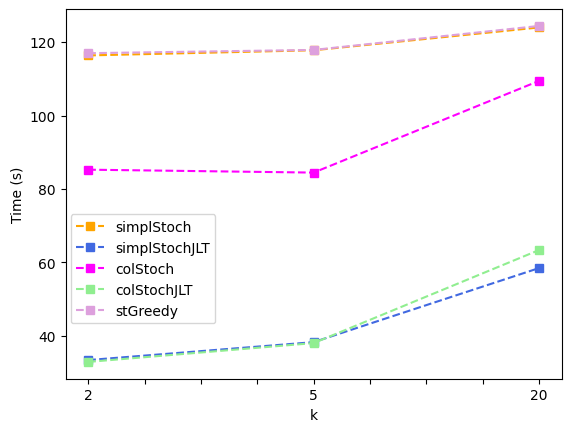

In [59]:
med_pvt = results.loc[(results['Instance'].isin(medium_graphs)) & (results['Experiment'] != 'specStoch') & (results['status'] == 'finished')].pivot_table(values='Amortized Time', index='k', columns='Experiment')
med_pvt.plot(kind='line', ylabel='Time (s)', title='', linestyle='--', marker='s', color=colormap)
plt.legend(loc=(0.01,.15))

In [35]:
normalized_results.pivot_table(values='Relative Quality', index='k', columns='Experiment', aggfunc=geometric_mean)

Experiment,simplStoch,simplStochJLT,colStoch,colStochJLT,specStoch
k,,,,,
2,0.797090,0.717665,0.963633,0.870413,0.059971
5,0.757199,0.703462,0.942522,0.876436,0.121705
20,0.690755,0.670780,0.885263,0.850527,0.188210


In [36]:
normalized_results.pivot_table(values='Relative Speedup', index='k', columns='Experiment', aggfunc=geometric_mean)

Experiment,simplStoch,simplStochJLT,colStoch,colStochJLT,specStoch
k,,,,,
2,1.007797,3.667752,0.879136,2.300567,0.143432
5,1.008819,2.473312,0.725920,1.324933,0.058027
20,1.012031,1.111961,0.471014,0.568726,0.012746
